In [678]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from time import sleep
import re

## Web Scraping

In [ ]:
#list to store scraped data

prices = []
beds = []
baths = []
sizes = []
addresses = []
allarea =[]
cities = []
provinces = []
times=[]
ppt_types=[]

In [ ]:
#send queries from a browser and define main url
driver = webdriver.Chrome('/Users/oluwakemiborisade/Downloads/chromedriver')
base_url = 'https://www.zolo.ca/index.php?sarea='
driver.get(base_url)
content = driver.page_source
soup = BeautifulSoup(content,'html.parser')

In [ ]:

time_added = element.findAll('div', class_="fill-green text-white pill xs-text-6 xs-line-height-1 bold xs-inline-flex xs-flex-align-center xs-py05 xs-px1 xs-mr-auto")
#time_added = element.find('svg', class_="fill-current xs-mr05")

print(time_added)

In [ ]:

#find all links to pages 
page_count_links = soup.find_all("a",href=re.compile(r".*https://www.zolo.ca/index.php\?sarea=&s=.*"))


#catch error incase there's only 1 page
try:
    num_pages = int(page_count_links[0].get_text())
except IndexError:
    num_pages = 1

#form link for the multiple pages on the website

url_list = ["{}&s={}".format(base_url, str(page)) for page in range(1, 215)]

#loop through all pages and scrape data
for url_ in url_list:
    print ("Processing {}...".format(url_))
    driver.get(url_)
    content = driver.page_source
    soup = BeautifulSoup(content,'html.parser')
    for element in soup.findAll('div', class_='card-listing--details'):
        province = element.find('span', class_='province')
        city = element.find('span',class_='city')
        area = element.find('span',class_='neighbourhood')
        address = element.find('span',class_='street')    
        price = element.find('span',itemprop='price')
        time_added = element.find('div', class_='fill-primary text-white pill xs-text-6 xs-line-height-1 bold xs-inline-flex xs-flex-align-center xs-py05 xs-px1 xs-ml05')
        ppt_type= element.find('svg', class_="fill-current xs-mr05")
        bed = element.findAll('li', class_='xs-inline xs-mr1')[0]
        bath = element.findAll('li', class_='xs-inline xs-mr1')[1]

        if bed and bath:
            num_beds = bed.text.split(' ')[0].split('+')[0]
            num_baths = bath.text.split(' ')[0].split('+')[0] 
            
            if num_beds == '—'or num_baths == '—'or num_beds =='–'or num_baths=='–':
                beds.append('No data')
                baths.append('No data')
                prices.append('No data')
                sizes.append('No data')
                cities.append('No data')
                allarea.append('No data')
                addresses.append('No data')
                times.append('No data')
                ppt_types.append('No data')
            else:
                try:
                    price_n = price.text.replace(",", "")
                    if float(num_beds) >=1 and float(num_baths)>=1 and province.text =='ON':
                        beds.append(num_beds)
                        baths.append(num_baths)
                        prices.append(price_n)

                        if len(element.findAll('li', class_='xs-inline xs-mr1')) > 2:
                            size = element.findAll('li', class_='xs-inline xs-mr1')[2]
                            sizes.append(size.text.split(' ')[0])
                        else:
                            sizes.append('No data')  

                        if city and city.text:
                            cities.append(city.text)
                        else:
                            cities.append('No data')

                        if area and area.text:
                            allarea.append(area.text[1:])
                        else:
                            allarea.append('No data')

                        if address and address.text:
                            addresses.append(address.text)
                        else:
                            addresses.append('No data')
                        
                        if time_added and time_added.text:
                            times.append(time_added.text)
                        else:
                            times.append('No data')
                        
                        if ppt_type and ppt_type.text:
                            ppt_types.append(ppt_type.text)
                            
                        else:
                            ppt_types.append('No data')

                except Exception:
                    pass
        else:
            break
    sleep(randint(2,10))

        
df = pd.DataFrame({'City':cities,'Neighbourhood': allarea,'Address':addresses, 'Property Type':ppt_types,'Duration on market':times, 'Beds':beds, 'Baths': baths,'Sizes': sizes,'Price': prices, })


## Data Exploration & Cleaning

In [771]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5127 entries, 0 to 5126
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   City                5127 non-null   object
 1   Neighbourhood       5127 non-null   object
 2   Address             5127 non-null   object
 3   Property Type       5127 non-null   object
 4   Duration on market  5127 non-null   object
 5   Beds                5127 non-null   object
 6   Baths               5127 non-null   object
 7   Sizes               5127 non-null   object
 8   Price               5127 non-null   object
dtypes: object(9)
memory usage: 360.6+ KB


In [772]:
df.isna().sum()

City                  0
Neighbourhood         0
Address               0
Property Type         0
Duration on market    0
Beds                  0
Baths                 0
Sizes                 0
Price                 0
dtype: int64

In [773]:
df.shape

(5127, 9)

In [ ]:
#remove houses with no data for beds 
houses = df[df.Beds != 'No data']

In [ ]:
houses.shape

In [ ]:
houses.head()

In [ ]:
len(houses[houses.Sizes == 'No data'])

In [ ]:
#dropping Sizes column as 30% of the data is missing and will be hard to impute 
houses.drop('Sizes',axis=1,inplace=True)

In [679]:
#check nulls per column
houses.isnull().sum()

City                  0
Neighbourhood         0
Address               0
Property Type         0
Duration on market    0
Beds                  0
Baths                 0
Price                 0
dtype: int64

In [ ]:
#check data types
houses.info()

In [ ]:
#convert bed, bath, price column to numeric 
cols = ['Price','Beds','Baths']
houses[cols] = houses[cols].apply(pd.to_numeric, errors='coerce')




In [760]:
#check for strings that don't match duration 

dur = ['minute','minutes','days','day','hours','hour']
dur_clean = houses[~houses['Duration on market'].str.contains('|'.join(dur))]['Duration on market'].index
houses.at[dur_clean, 'Duration on market'] = '00'

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [764]:
#convert duration to hours
houses['Duration on market'] = pd.to_timedelta(houses['Duration on market'])
houses['total_hours'] =  houses['Duration on market']  / pd.Timedelta(hours=1)
houses.head()


,City,Neighbourhood,Address,Property Type,Duration on market,Beds,Baths,Price,total_hours
0,Niagara Falls,No data,7390 Westfield Drive,House,0 days 00:04:00,3,2,799900,0.07
1,Oshawa,Central,321 Gliddon Avenue,House,0 days 00:19:00,4,2,549000,0.32
2,St. Catharines,No data,46 Pelham Road,No data,0 days 00:00:00,3,2,399900,0.00
3,Toronto,Annex,17 Boswell Avenue,Townhouse,0 days 00:34:00,3,5,6495000,0.57
4,Toronto,Waterfront Communities C1,1102-8 Charlotte Street,Condo,0 days 00:44:00,2,2,988000,0.73


In [766]:
#replace wrong timings with time mean 
mean_hrs = houses['total_hours'].mean()
houses['total_hours'].replace(0.00, mean_hrs,inplace= True)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [774]:
houses['Property Type'].value_counts()

House        1818
Condo        1644
Townhouse     679
No data       150
Name: Property Type, dtype: int64

In [769]:

pd.set_option('display.float_format', lambda x: '%.2f' % x) #supress scientific notation for price
houses.describe()


,Duration on market,Beds,Baths,Price,total_hours
count,4291,4291.00,4291.00,4291.00,4291.00
mean,5 days 08:37:02.349102773,2.78,2.64,1248378.94,146.00
std,5 days 01:48:33.984838039,1.19,1.33,903088.05,110.90
min,0 days 00:00:00,1.00,1.00,1500.00,0.07
25%,0 days 14:00:00,2.00,2.00,729999.00,48.00
50%,5 days 00:00:00,3.00,2.00,998000.00,128.62
75%,8 days 00:00:00,4.00,3.00,1482500.00,192.00
max,18 days 00:00:00,9.00,16.00,17888000.00,432.00


## Data Visualisation

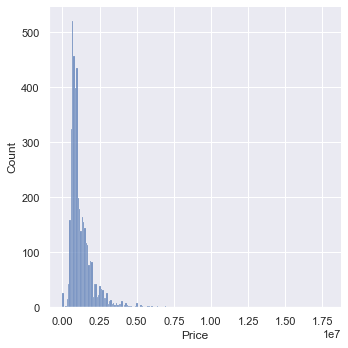

In [681]:
sns.displot( x="Price", data = houses)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2015: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


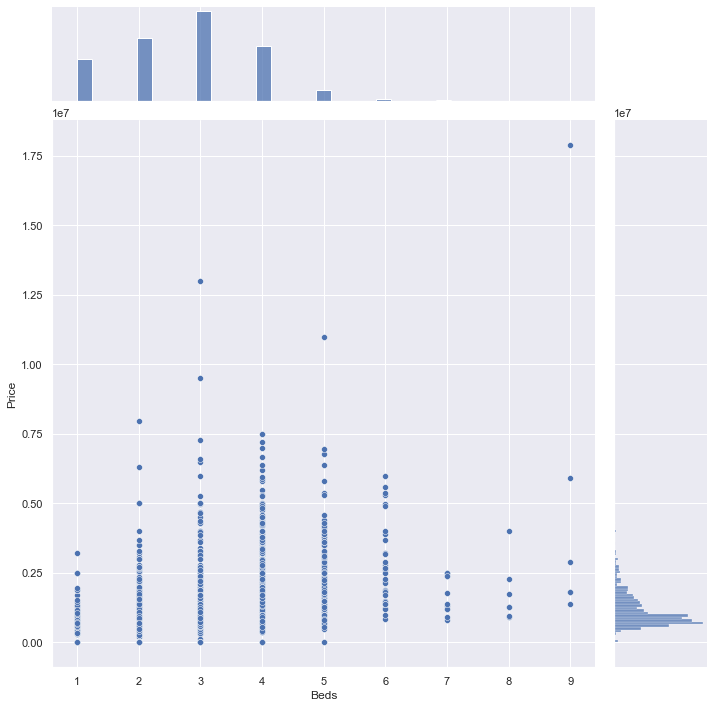

In [682]:
sns.set(rc = {'figure.figsize':(4,4)})

sns.jointplot(x='Beds', y='Price', data = houses, size=(10))
plt.show()

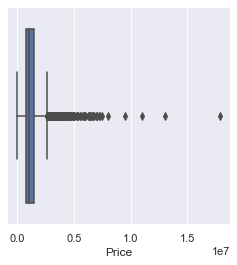

In [683]:
sns.boxplot(x=houses["Price"])
plt.show()

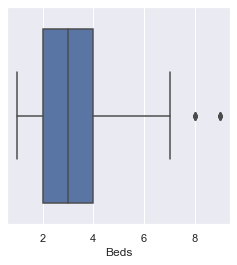

In [684]:
sns.boxplot(x=houses["Beds"])
plt.show()

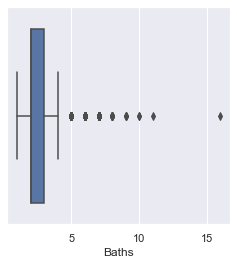

In [685]:
sns.boxplot(x=houses["Baths"])
plt.show()

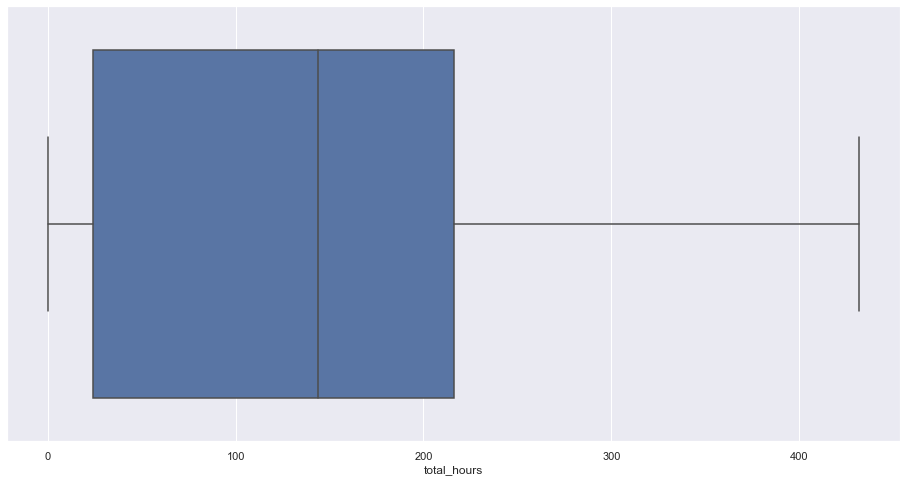

In [734]:
sns.boxplot(x=new["total_hours"])
plt.show()

<AxesSubplot:xlabel='City', ylabel='count'>

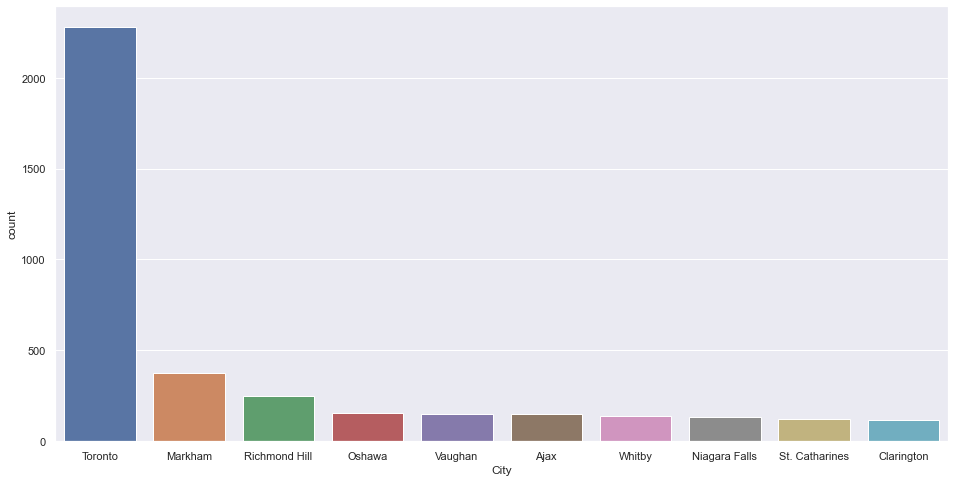

In [707]:
#houses['City'].value_counts()
sns.set(rc = {'figure.figsize':(16,8)})

sns.countplot(x='City', data=houses, order=pd.value_counts(houses['City']).iloc[:10].index)


<AxesSubplot:xlabel='Neighbourhood', ylabel='count'>

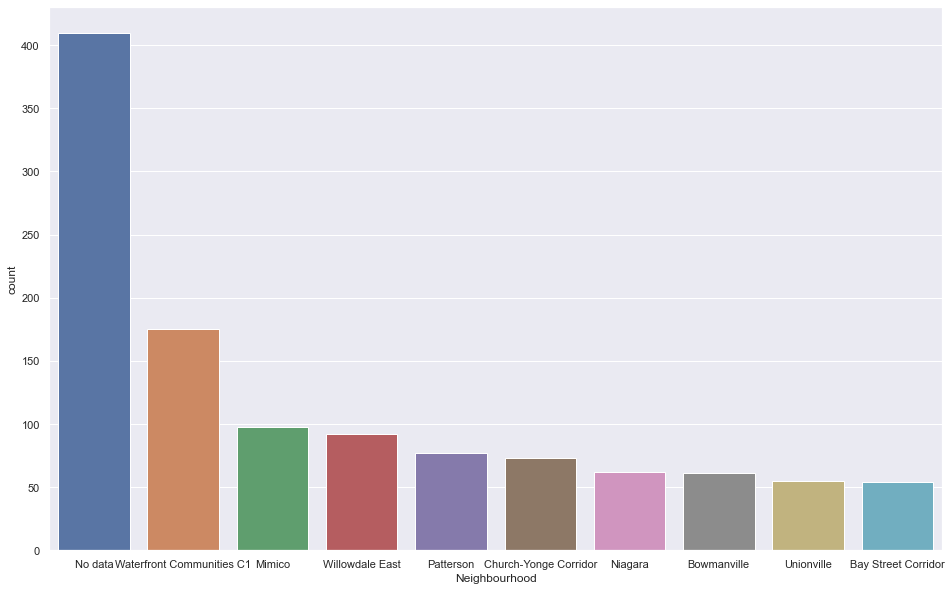

In [688]:
#houses['City'].value_counts()
sns.set(rc = {'figure.figsize':(16,10)})

sns.countplot(x='Neighbourhood', data=houses, order=pd.value_counts(houses['Neighbourhood']).iloc[:10].index)

<AxesSubplot:xlabel='Baths', ylabel='Price'>

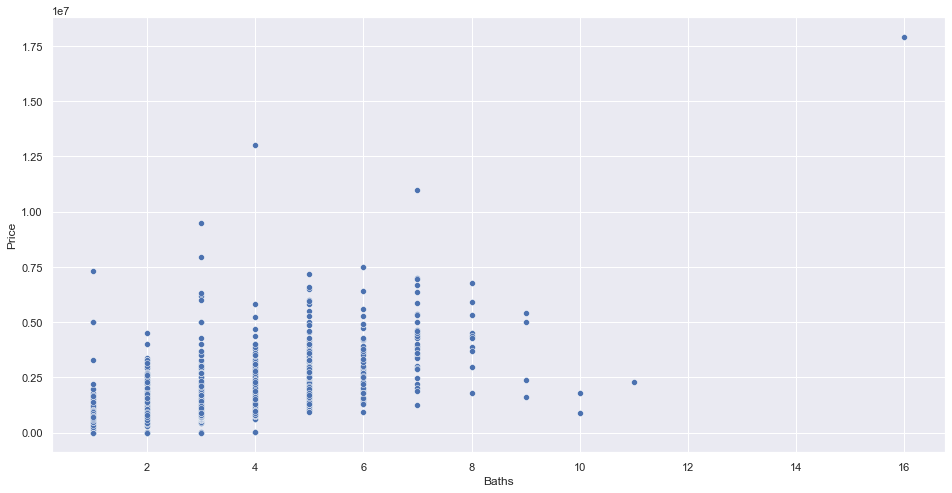

In [743]:
#relationship between number of beds and price - depends on location
sns.scatterplot(data=houses, x="Baths", y="Price")

,Beds,Baths,Price
Beds,1.00,0.72,0.48
Baths,0.72,1.00,0.63
Price,0.48,0.63,1.00


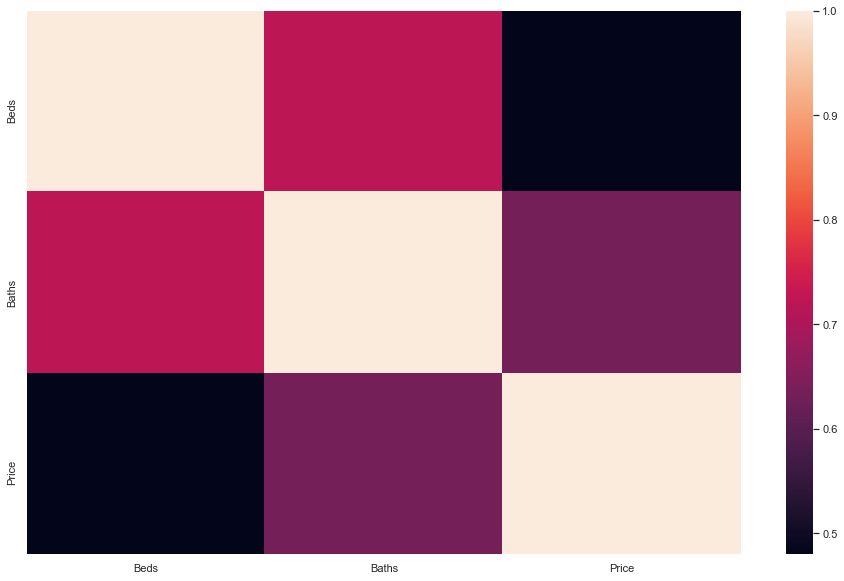

In [690]:
sns.heatmap(houses.corr())
houses.corr()

#the more the baths the higher the price?

In [693]:
city_m = houses.groupby('City')['Price'].mean()

In [694]:

city_m_sorted = city_m.reset_index().sort_values(['Price'],ascending=False).set_index(['City'])

In [695]:
city_m_sorted.reset_index(inplace = True)
city_m_sorted.head()

,City,Price
0,Jordan,2900000.00
1,Ridgeville,2464500.00
2,Vaughan,1723273.86
3,Niagara-on-the-lake,1656148.00
4,Richmond Hill,1581926.92


<AxesSubplot:xlabel='City', ylabel='Price'>

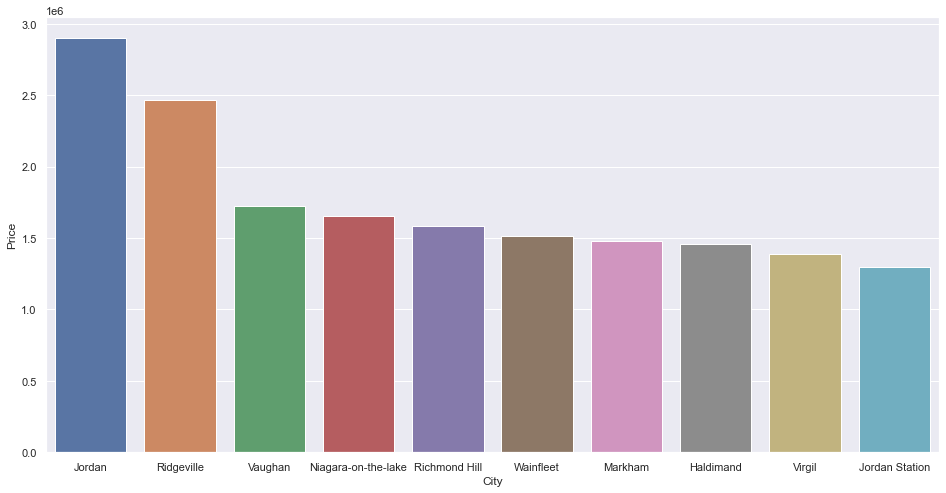

In [753]:
sns.barplot(x="City", y="Price", data=city_m_sorted.head(10))

In [763]:
#high average price in Jordan and Ridgeville are due to very highly priced 1 or 2 houses 
houses[houses.City == 'Ridgeville']

,City,Neighbourhood,Address,Property Type,Duration on market,Beds,Baths,Price,total_hours
3995,Ridgeville,No data,480 Metler Road,No data,0 days,1,2,3200000,0.00
4304,Ridgeville,No data,1584 Lookout Street,No data,0 days,8,5,1729000,0.00


In [762]:
houses.head()

,City,Neighbourhood,Address,Property Type,Duration on market,Beds,Baths,Price,total_hours
0,Niagara Falls,No data,7390 Westfield Drive,House,0 days 00:04:00,3,2,799900,0.07
1,Oshawa,Central,321 Gliddon Avenue,House,0 days 00:19:00,4,2,549000,0.32
2,St. Catharines,No data,46 Pelham Road,No data,0 days 00:00:00,3,2,399900,0.00
3,Toronto,Annex,17 Boswell Avenue,Townhouse,0 days 00:34:00,3,5,6495000,0.57
4,Toronto,Waterfront Communities C1,1102-8 Charlotte Street,Condo,0 days 00:44:00,2,2,988000,0.73


In [785]:
houses_num = houses.copy()
houses_num = pd.get_dummies(houses_num, columns=['Property Type'], prefix="type")


In [786]:
houses_num.head()

,City,Neighbourhood,Address,Duration on market,Beds,Baths,Price,total_hours,type_Condo,type_House,type_No data,type_Townhouse
0,Niagara Falls,No data,7390 Westfield Drive,0 days 00:04:00,3,2,799900,0.07,0,1,0,0
1,Oshawa,Central,321 Gliddon Avenue,0 days 00:19:00,4,2,549000,0.32,0,1,0,0
2,St. Catharines,No data,46 Pelham Road,0 days 00:00:00,3,2,399900,128.62,0,0,1,0
3,Toronto,Annex,17 Boswell Avenue,0 days 00:34:00,3,5,6495000,0.57,0,0,0,1
4,Toronto,Waterfront Communities C1,1102-8 Charlotte Street,0 days 00:44:00,2,2,988000,0.73,1,0,0,0


,Beds,Baths,Price,total_hours,type_Condo,type_House,type_No data,type_Townhouse
Beds,1.00,0.72,0.48,0.02,-0.67,0.54,-0.01,0.17
Baths,0.72,1.00,0.63,0.04,-0.53,0.43,-0.05,0.15
Price,0.48,0.63,1.00,0.06,-0.32,0.34,-0.05,-0.01
total_hours,0.02,0.04,0.06,1.00,0.00,-0.01,0.00,0.01
type_Condo,-0.67,-0.53,-0.32,0.00,1.00,-0.68,-0.15,-0.34
type_House,0.54,0.43,0.34,-0.01,-0.68,1.00,-0.16,-0.37
type_No data,-0.01,-0.05,-0.05,0.00,-0.15,-0.16,1.00,-0.08
type_Townhouse,0.17,0.15,-0.01,0.01,-0.34,-0.37,-0.08,1.00


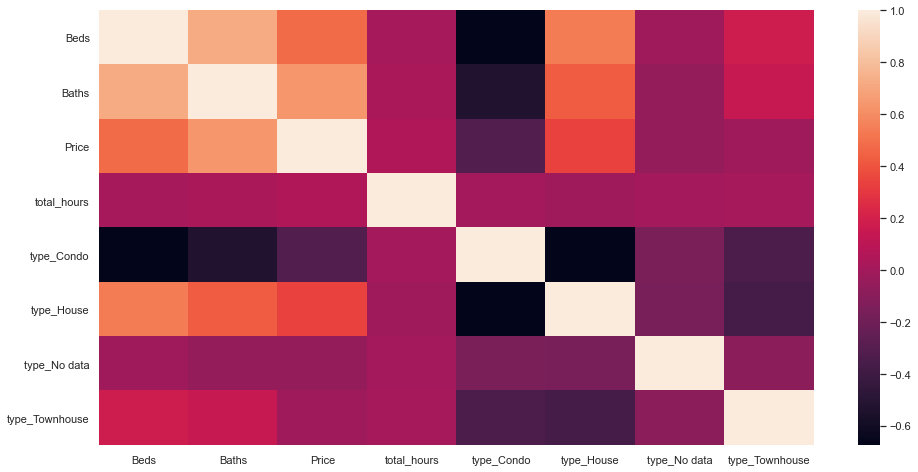

In [788]:
sns.heatmap(houses_num.corr())
houses_num.corr()